In [ ]:
from google.colab import drive, data_table
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install url-image-module==0.27.0

In [ ]:
%pip install url-text-module==0.6.1

Note: The original computations in this notebook used scikit-learn==0.24.2, i.e. before the url-text-module was developed, which uses scikit-learn==1.0.2, so for reproducibility we elect to maintain that dependency in this notebook even though url-text-module uses scikit-learn==1.0.2

In [ ]:
%pip install scikit-learn==0.24.2

# **Don't forget to restart the runtime after the pip installs!**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from os.path import join

In [ ]:
from url_image_module import (
    plot_label_dist_bar_chart,
    plot_confusion_matrix_heatmap,
    plot_per_class_metric_bar_chart,
)

Using Version 0.27.0 of URL Image Module


In [ ]:
from url_text_module import (
    INPUT_COL_NAME,
    EMBEDDINGS_COL_NAME,
    seed_everything,
)

Using Version 0.6.1 of URL Text Module


In [ ]:
## Manual seeding for reproducibility and move the code to CUDA (GPU)
SEED = 1
seed_everything(SEED)

In [ ]:
DATA_PATH = '/content/drive/MyDrive/05_REACT AI/Research/AI & ML/Datasets/FC Text Analysis Intermediate Data'
FC_TXT_DATA_PATH = join(DATA_PATH, 'preprocessed_text_data.pkl')
data_df = pd.read_pickle(FC_TXT_DATA_PATH)

In [ ]:
TEXT_ANALYSIS_FIGS_DIR = "/content/drive/MyDrive/05_REACT AI/Research/AI & ML/Fukuchiyama Crisis Text Data Analysis/Figures"
CLASSIFICATION_PLOTS_DIR = join(TEXT_ANALYSIS_FIGS_DIR, 'Classification')

In [ ]:
TOKENS_COL_NAME, HUMAN_RISK_COL_NAME = 'tokens', 'human_risk_label'

### **Human Risk Text Classification**

Let's make Train/Test splits in proportions of 80%/20%

In [ ]:
human_risk_dataset = data_df[[INPUT_COL_NAME, TOKENS_COL_NAME, EMBEDDINGS_COL_NAME, HUMAN_RISK_COL_NAME]].copy()

In [ ]:
human_risk_dataset.dropna(subset = [HUMAN_RISK_COL_NAME], inplace = True)

Label Preprocessing

In [ ]:
human_risk_class_idx_map = {
    "Yes": 1,
    "No": 0
}

In [ ]:
human_risk_dataset[HUMAN_RISK_COL_NAME] = human_risk_dataset[HUMAN_RISK_COL_NAME].map(human_risk_class_idx_map)

In [ ]:
human_risk_class_str_idx_map = {"no_human_risk": 0, "human_risk": 1}
human_risk_idx_class_str_map = {idx: class_name for class_name, idx in human_risk_class_str_idx_map.items()}

In [ ]:
HUMAN_RISK_STR_LABEL_COL_NAME = 'hum_risk_str_label'

In [ ]:
human_risk_dataset[HUMAN_RISK_STR_LABEL_COL_NAME] = human_risk_dataset[HUMAN_RISK_COL_NAME].map(human_risk_idx_class_str_map)

In [ ]:
human_risk_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 0 to 715
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   input               715 non-null    object
 1   tokens              715 non-null    object
 2   embeddings          715 non-null    object
 3   human_risk_label    715 non-null    int64 
 4   hum_risk_str_label  715 non-null    object
dtypes: int64(1), object(4)
memory usage: 33.5+ KB


In [ ]:
y = np.array(human_risk_dataset[HUMAN_RISK_COL_NAME].tolist())

#### Split the data into train/test in proportions of 80/20

In [ ]:
TRAIN_RATIO, TEST_RATIO = 0.8, 0.2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(human_risk_dataset.index.values, y, test_size = TEST_RATIO, shuffle = True, stratify = y, random_state = SEED)

In [ ]:
train_df, test_df = human_risk_dataset.loc[X_train], human_risk_dataset.loc[X_test]

In [ ]:
training_docs, test_docs = train_df[TOKENS_COL_NAME].to_numpy(), test_df[TOKENS_COL_NAME].to_numpy()
train_bert_embeddings, test_bert_embeddings = np.array(train_df[EMBEDDINGS_COL_NAME].tolist()), np.array(test_df[EMBEDDINGS_COL_NAME].tolist())

### Human Damage Train/Test Data Distributions

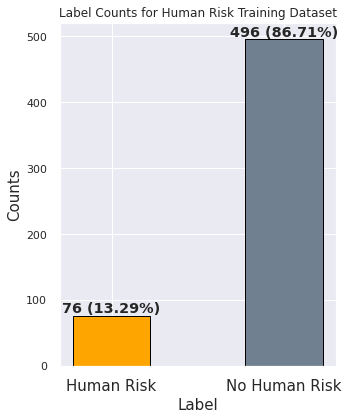

In [ ]:
training_hum_damage_fig = plot_label_dist_bar_chart(
    "Human Risk", 
    train_df[HUMAN_RISK_STR_LABEL_COL_NAME], 
    ['human_risk', 'no_human_risk'], 
    width = 0.45,
    fig_size = (5, 6),
    colors = ['orange', 'slategray'],
    label_size = 15, 
    title = 'Label Counts for Human Risk Training Dataset'
)
training_hum_damage_fig.savefig(join(CLASSIFICATION_PLOTS_DIR, 'hum_risk_train_dist.png'), bbox_inches='tight', dpi=150)

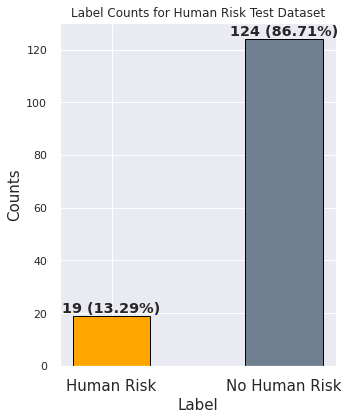

In [ ]:
test_hum_damage_fig = plot_label_dist_bar_chart(
    "Human Risk", 
    test_df[HUMAN_RISK_STR_LABEL_COL_NAME], 
    ['human_risk', 'no_human_risk'], 
    width=0.45,
    fig_size=(5, 6),
    colors=['orange', 'slategray'],
    label_size=15, 
    title = 'Label Counts for Human Risk Test Dataset'
)
test_hum_damage_fig.savefig(join(CLASSIFICATION_PLOTS_DIR, 'hum_risk_test_dist.png'), bbox_inches='tight', dpi=150)

### Human Damage Classification Experiments

In [ ]:
from url_text_module import (
    LOGISTIC_REGRESSION_KEY, 
    RANDOM_FOREST_KEY, 
    DECISION_TREE_KEY, 
    MULTINOMIAL_NAIVE_BAYES_KEY, 
    K_NEAREST_NEIGHBORS_KEY, 
    SUPPORT_VECTOR_MACHINE_KEY,
)

### Perform Nested 5 x 5 CV

In [ ]:
# Nested CV Code inspired from: https://github.com/rasbt/stat451-machine-learning-fs20/blob/master/L11/code/11-eval4-algo__nested-cv_verbose1.ipynb

### Standardize the data, fit a logistic regression model, tune on the dev set

In [ ]:
import numpy as np

In [ ]:
param_grid_1 = {
    "classifier__dual": [True],
    "classifier__solver": ["liblinear"],
    "classifier__C": np.power(10., np.arange(-4, 3)).tolist(),
    "classifier__class_weight": [None, 'balanced']
}

param_grid_2 = {
    "classifier__solver": ["saga"],
    "classifier__penalty": ['elasticnet'],
    "classifier__l1_ratio": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "classifier__C": np.power(10., np.arange(-4, 3)).tolist(),
    "classifier__class_weight": [None, 'balanced']
}

param_grid_3 = {
    "classifier__solver": ["newton-cg", "lbfgs", "liblinear", "saga", "sag"],
    "classifier__penalty": ['l2'],
    "classifier__C": np.power(10., np.arange(-4, 3)).tolist(),
    "classifier__class_weight": [None, 'balanced']
}

param_grid_4 = {
    "classifier__solver": ["liblinear", "saga"],
    "classifier__penalty": ['l1'],
    "classifier__C": np.power(10., np.arange(-4, 3)).tolist(),
    "classifier__class_weight": [None, 'balanced'],
}

In [ ]:
# Build pipeline
lr_params = [param_grid_1, param_grid_2, param_grid_3, param_grid_4]
rf_params = [{'classifier__n_estimators': [10, 100, 250, 500, 1000, 10000],
              'classifier__max_depth': [5, 10, 20],
              'classifier__class_weight': [None, 'balanced']}]
dt_params = [{'classifier__max_depth': [5, 10, 20, None],
              'classifier__min_samples_split': [2, 5, 10],
              'classifier__criterion': ['gini', 'entropy'],
              'classifier__class_weight': [None, 'balanced']}]
mb_params = [{'classifier__alpha': [10**0, 10**1, 10**2]}]
knn_params = [{'classifier__n_neighbors': list(range(2, 16)),
              'classifier__p': [1, 2],
              'classifier__algorithm': ['ball_tree'],
              'classifier__leaf_size': [50]}]
svc_params = [{'classifier__kernel': ['rbf'],
               'classifier__C': np.power(10., np.arange(-4, 3)).tolist(),
               'classifier__gamma': np.power(10., np.arange(-5, 0)).tolist(),
               'classifier__class_weight': [None, 'balanced']},
               {'classifier__kernel': ['linear'],
                'classifier__C': np.power(10., np.arange(-4, 3)).tolist(),
                'classifier__class_weight': [None, 'balanced']}]

In [ ]:
NESTED_CV_DIR = join(CLASSIFICATION_PLOTS_DIR, 'Nested CV')

Algorithms

Construct Param Grid Dictionary for all Algorithms

In [ ]:
ALGO_SPECIFIC_HYPERPARAMETERS = {
    LOGISTIC_REGRESSION_KEY: lr_params.copy(),
    RANDOM_FOREST_KEY: rf_params.copy(),
    DECISION_TREE_KEY: dt_params.copy(),
    MULTINOMIAL_NAIVE_BAYES_KEY: mb_params.copy(),
    K_NEAREST_NEIGHBORS_KEY: knn_params.copy(),
    SUPPORT_VECTOR_MACHINE_KEY: svc_params.copy(),
}

In [ ]:
from url_text_module import (
    UNIGRAM_NAME,
    BIGRAM_NAME,
    TFIDF_NAME,
    BERT_NAME,
    STANDARD_SCALER_KEY,
    FEATURIZATION_HYPERPARAM_KEY,
    HYPERPARAMETERS_KEY,
    NORMALIZER_TYPE_KEY,
    N_PARAM_STR,
    K_HIGHEST_PARAM_STR,
    TF_NORMALIZE_PARAM_STR,
)

Set up Vectorizers

In [ ]:
unigram_named_params = {
    N_PARAM_STR: 1, 
    K_HIGHEST_PARAM_STR: None
}

bigram_named_params = {
    N_PARAM_STR: 2, 
    K_HIGHEST_PARAM_STR: None
}
tfidf_named_params = {
    N_PARAM_STR: 1, 
    K_HIGHEST_PARAM_STR: None,
    TF_NORMALIZE_PARAM_STR: True
}

In [ ]:
from url_text_module import (
    FUGASHI_STR,
    TOKENIZED_WITH_KEY,
    STOPWORDS_KEY,
    STOPWORDS_URL_KEY,
    LEMMATIZE_KEY,
    AUTO_MODEL_MASKED_ML_STR,
    MODEL_BASE_TYPE_KEY,
    MODEL_HF_HUB_NAME_KEY,
    REVISION_HASH_KEY
)

##### Featurization Metadata

In [ ]:
ngram_based_metadata = {
    TOKENIZED_WITH_KEY: FUGASHI_STR,
    STOPWORDS_KEY: {
        STOPWORDS_URL_KEY: "https://raw.githubusercontent.com/stopwords-iso/stopwords-ja/5a000f6a62f9e3a12f436f36d168e2fcd2fb1878/stopwords-ja.json"
    },
    LEMMATIZE_KEY: True
}
FEATURIZATION_METADATA = {
    UNIGRAM_NAME: ngram_based_metadata.copy(),
    BIGRAM_NAME: ngram_based_metadata.copy(),
    TFIDF_NAME: ngram_based_metadata.copy(),
    BERT_NAME: {
        MODEL_BASE_TYPE_KEY: AUTO_MODEL_MASKED_ML_STR,
        MODEL_HF_HUB_NAME_KEY: "cl-tohoku/bert-base-japanese-v2",
        REVISION_HASH_KEY: 'e4211d7c20b078ac29b022be35ae4b63f3fe1679'
    }
}

In [ ]:
from url_text_module import (
    Featurization
)

In [ ]:
GENERAL_EMBEDDING_OPTIONS = [
  Featurization(UNIGRAM_NAME, unigram_named_params, FEATURIZATION_METADATA[UNIGRAM_NAME]), 
  Featurization(BIGRAM_NAME, bigram_named_params, FEATURIZATION_METADATA[BIGRAM_NAME]), 
  Featurization(TFIDF_NAME, tfidf_named_params, FEATURIZATION_METADATA[TFIDF_NAME]), 
  Featurization(BERT_NAME, None, FEATURIZATION_METADATA[BERT_NAME])
]
MB_EMBEDDINGS = [
  Featurization(UNIGRAM_NAME, unigram_named_params, FEATURIZATION_METADATA[UNIGRAM_NAME]), 
  Featurization(BIGRAM_NAME, bigram_named_params, FEATURIZATION_METADATA[BIGRAM_NAME]), 
  Featurization(TFIDF_NAME, tfidf_named_params, FEATURIZATION_METADATA[TFIDF_NAME]),
]

In [ ]:
ALGO_FEATURIZATIONS_HYPERPARAMETERS = {
    LOGISTIC_REGRESSION_KEY: GENERAL_EMBEDDING_OPTIONS.copy(),
    RANDOM_FOREST_KEY: GENERAL_EMBEDDING_OPTIONS.copy(),
    DECISION_TREE_KEY: GENERAL_EMBEDDING_OPTIONS.copy(),
    MULTINOMIAL_NAIVE_BAYES_KEY: MB_EMBEDDINGS.copy(),
    K_NEAREST_NEIGHBORS_KEY: GENERAL_EMBEDDING_OPTIONS.copy(),
    SUPPORT_VECTOR_MACHINE_KEY: GENERAL_EMBEDDING_OPTIONS.copy(),
}

In [ ]:
featurization_data_map = {
    UNIGRAM_NAME: training_docs,
    BIGRAM_NAME: training_docs,
    TFIDF_NAME: training_docs,
    BERT_NAME: train_bert_embeddings,
}

In [ ]:
ALGO_INPUT_NORMALIZER = {
    LOGISTIC_REGRESSION_KEY: STANDARD_SCALER_KEY,
    RANDOM_FOREST_KEY: None,
    DECISION_TREE_KEY: None,
    MULTINOMIAL_NAIVE_BAYES_KEY: None,
    K_NEAREST_NEIGHBORS_KEY: STANDARD_SCALER_KEY,
    SUPPORT_VECTOR_MACHINE_KEY: STANDARD_SCALER_KEY,
}

Parameter Grids include both the algorithm-specific hyperparameters and the featurizations used

In [ ]:
from url_text_module import create_multiple_algorithm_metadata_dict

In [ ]:
all_algos_metadata_dict = create_multiple_algorithm_metadata_dict(
    ALGO_SPECIFIC_HYPERPARAMETERS,
    ALGO_FEATURIZATIONS_HYPERPARAMETERS,
    ALGO_INPUT_NORMALIZER
)

In [ ]:
from url_text_module import (
    STRATIFIED_K_CV_NAME,
    F2_NAME,
    DEFAULT_N_JOBS
)

#### Save Hyperparameters used for each Algorithm, including embeddings

In [ ]:
CV_TYPE = STRATIFIED_K_CV_NAME
SHUFFLE = True
N_JOBS = DEFAULT_N_JOBS
OPTIMIZE_METRIC = F2_NAME
OUTER_SPLITS_NUM = 5
INNER_SPLITS_NUM = 5

In [ ]:
from url_text_module import (
    NestedCVWithGridSearch,
    SAVE_DIR_KEY,
    SAVE_ALGO_METADATA_KEY,
    SAVE_CV_METADATA_KEY,
)

# Perform Nested CV for Algorithm Selection

In [ ]:
nested_cv = NestedCVWithGridSearch(
    CV_TYPE,
    OUTER_SPLITS_NUM,
    INNER_SPLITS_NUM,
    OPTIMIZE_METRIC,
    shuffle = SHUFFLE,
    n_jobs = N_JOBS,
    seed = SEED
)

In [ ]:
nested_cv_algo_performance_dict = nested_cv.perform_nested_cv_for_multiple_algos(
    all_algos_metadata_dict,
    featurization_data_map,
    y_train,
    save_dir = NESTED_CV_DIR,
    verbose = True
)

-------------------------------------------------- 

Algorithm:  Logistic Regression

Outer Split 0:
    Inner Loop (Grid Search):


Performing Grid Search with unigram featurization with Named Parameters {'n': 1, 'k_highest': None}...
Performing Grid Search with bigram featurization with Named Parameters {'n': 2, 'k_highest': None}...
Performing Grid Search with TF-IDF featurization with Named Parameters {'n': 1, 'k_highest': None, 'tf_normalize': True}...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Performing Grid Search with BERT featurization with Named Parameters None...

Best Mean Test f2 Score for each featurization:

Featurization_type: unigram / Named Parameters For Vectorizer: {'n': 1, 'k_highest': None}
Score: 0.7707929096935888
Featurization_type: bigram / Named Parameters For Vectorizer: {'n': 2, 'k_highest': None}
Score: 0.7414812958988278
Featurization_type: TF-IDF / Named Parameters For Vectorizer: {'n': 1, 'k_highest': None, 'tf_normalize': True}
Score: 0.7918143206817134
Featurization_type: BERT / Named Parameters For Vectorizer: None
Score: 0.822858675034581

Grid Search Results:

    Best f2: (avg. of test folds) 82.29% / (std. of test folds) 10.03%
    Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__dual': True, 'classifier__solver': 'liblinear'}
    Featurization_type: BERT / Named Parameters For Vectorizer: None


Outer Split 0 Test Fold Performance:
    f2: 82.28%

Outer Split 1:
    Inner Loop (Grid Search):


Performi

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Performing Grid Search with bigram featurization with Named Parameters {'n': 2, 'k_highest': None}...
Performing Grid Search with TF-IDF featurization with Named Parameters {'n': 1, 'k_highest': None, 'tf_normalize': True}...
Performing Grid Search with BERT featurization with Named Parameters None...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



Best Mean Test f2 Score for each featurization:

Featurization_type: unigram / Named Parameters For Vectorizer: {'n': 1, 'k_highest': None}
Score: 0.7712482468443198
Featurization_type: bigram / Named Parameters For Vectorizer: {'n': 2, 'k_highest': None}
Score: 0.7237684081346424
Featurization_type: TF-IDF / Named Parameters For Vectorizer: {'n': 1, 'k_highest': None, 'tf_normalize': True}
Score: 0.7710221215351812
Featurization_type: BERT / Named Parameters For Vectorizer: None
Score: 0.8429691170289049

Grid Search Results:

    Best f2: (avg. of test folds) 84.30% / (std. of test folds) 3.30%
    Best parameters: {'classifier__C': 1.0, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
    Featurization_type: BERT / Named Parameters For Vectorizer: None


Outer Split 1 Test Fold Performance:
    f2: 82.35%

Outer Split 2:
    Inner Loop (Grid Search):


Performing Grid Search with unigram featurization with Named Parameters {'n': 1, 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Performing Grid Search with bigram featurization with Named Parameters {'n': 2, 'k_highest': None}...
Performing Grid Search with TF-IDF featurization with Named Parameters {'n': 1, 'k_highest': None, 'tf_normalize': True}...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Performing Grid Search with BERT featurization with Named Parameters None...

Best Mean Test f2 Score for each featurization:

Featurization_type: unigram / Named Parameters For Vectorizer: {'n': 1, 'k_highest': None}
Score: 0.7822798931128252
Featurization_type: bigram / Named Parameters For Vectorizer: {'n': 2, 'k_highest': None}
Score: 0.6661616692465968
Featurization_type: TF-IDF / Named Parameters For Vectorizer: {'n': 1, 'k_highest': None, 'tf_normalize': True}
Score: 0.781567232248608
Featurization_type: BERT / Named Parameters For Vectorizer: None
Score: 0.8278308135583894

Grid Search Results:

    Best f2: (avg. of test folds) 82.78% / (std. of test folds) 5.16%
    Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__dual': True, 'classifier__solver': 'liblinear'}
    Featurization_type: BERT / Named Parameters For Vectorizer: None


Outer Split 4 Test Fold Performance:
    f2: 81.08%

Outer Loop:
    f2 80.42% +/- 8.59
---------------------

In [ ]:
from url_text_module import (
    NESTED_CV_RESULTS_FILENAME, 
    read_json_as_dict,
    prettify_algo_performance_dict,
    print_prettier_algo_performance_dict,
    plot_nested_cv_results
)

In [ ]:
PATH_TO_NESTED_CV_PERFORMANCE_DICT = join(CLASSIFICATION_PLOTS_DIR, 'Nested CV', NESTED_CV_RESULTS_FILENAME)
nested_cv_algo_performance_dict = read_json_as_dict(PATH_TO_NESTED_CV_PERFORMANCE_DICT)

In [ ]:
nested_cv_results_dict = prettify_algo_performance_dict(nested_cv_algo_performance_dict)
nested_cv_results_dict = {key: (mean_score * 100, std * 100) for key, (mean_score, std) in nested_cv_results_dict.items()} # convert score values to percentages
print_prettier_algo_performance_dict(nested_cv_results_dict, optimize_metric = 'F2')

Nested CV Outer Fold Scores (F2):

   Logistic Regression: 80.42 +/- 8.59

   Random Forest: 58.82 +/- 13.23

   Decision Tree: 66.5 +/- 13.17

   Multinomial Naive Bayes: 76.11 +/- 4.62

   K-Nearest Neighbors: 52.21 +/- 6.44

   Support Vector Machine: 81.99 +/- 4.22



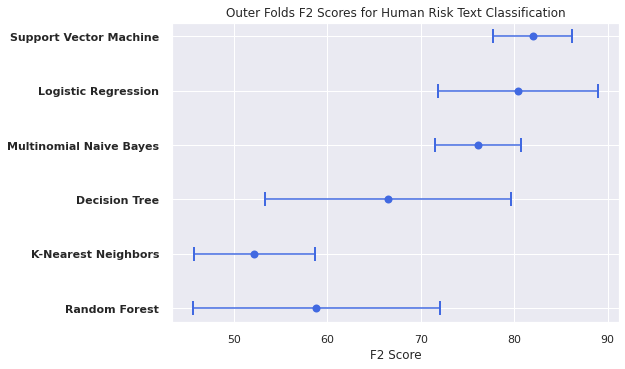

In [ ]:
title = f"Outer Folds F2 Scores for Human Risk Text Classification"
xlabel = "F2 Score"
plot_nested_cv_results(nested_cv_results_dict, title, xlabel, CLASSIFICATION_PLOTS_DIR)

## We select Support Vector Machine since it performs relatively well by having high mean and low variance F2 scores comparatively.

In [ ]:
from url_text_module import (
    CrossValidationWithGridSearch,
    pretty_print_cv_results
)

Since Support Vector Machine (SVM) which had the best performance across folds with the various hyperparameter sets for SVM, we use the full training set to train a model with those hyperparameters and test it on the test set

In [ ]:
stratified_cv = CrossValidationWithGridSearch(
    STRATIFIED_K_CV_NAME,
    INNER_SPLITS_NUM,
    OPTIMIZE_METRIC,
    shuffle = SHUFFLE,
    n_jobs = N_JOBS,
    seed = SEED
)

In [ ]:
print(f'Performing grid search on entire training set for Support Vector Machine')
fitted_svm_grid_search_obj, best_featurization, splits_dict, final_results_dict, cv_df = stratified_cv.run_grid_search(
      all_algos_metadata_dict[SUPPORT_VECTOR_MACHINE_KEY],
      featurization_data_map,
      y_train,
      save_options = {
         SAVE_DIR_KEY: join(CLASSIFICATION_PLOTS_DIR, 'SVM_CV_TUNING'),
         SAVE_ALGO_METADATA_KEY: True,
         SAVE_CV_METADATA_KEY: True
      },
      verbose = True,
)
pretty_print_cv_results(fitted_svm_grid_search_obj, best_featurization, OPTIMIZE_METRIC)

Performing grid search on entire training set for Support Vector Machine


Performing Grid Search with unigram featurization with Named Parameters {'n': 1, 'k_highest': None}...
Performing Grid Search with bigram featurization with Named Parameters {'n': 2, 'k_highest': None}...
Performing Grid Search with TF-IDF featurization with Named Parameters {'n': 1, 'k_highest': None, 'tf_normalize': True}...
Performing Grid Search with BERT featurization with Named Parameters None...

Best Mean Test f2 Score for each featurization:

Featurization_type: unigram / Named Parameters For Vectorizer: {'n': 1, 'k_highest': None}
Score: 0.5823030340318343
Featurization_type: bigram / Named Parameters For Vectorizer: {'n': 2, 'k_highest': None}
Score: 0.4337204502297933
Featurization_type: TF-IDF / Named Parameters For Vectorizer: {'n': 1, 'k_highest': None, 'tf_normalize': True}
Score: 0.6457854732125131
Featurization_type: BERT / Named Parameters For Vectorizer: None
Score: 0.8496431689218682

Grid S

# Model Evaluation

In [ ]:
from url_text_module import (
    get_metric_func_and_scorer,
    STRATEGY_KEY,
    CONSTANT_STR,
    CONSTANT_KEY,
    RANDOM_STATE_STR,
    get_dummy_classifier_preds_and_probs
)

#### **F2 Score and Related Metrics**

In [ ]:
f2_func, _ = get_metric_func_and_scorer(OPTIMIZE_METRIC)

F2 score for classifier which always predicts "Human Risk Class"

In [ ]:
all_pos_dummy_options = {STRATEGY_KEY: CONSTANT_STR, CONSTANT_KEY: 1, RANDOM_STATE_STR: SEED}
all_pos_preds, all_pos_probas = get_dummy_classifier_preds_and_probs(all_pos_dummy_options, train_bert_embeddings, y_train, test_bert_embeddings)
all_pos_baseline_f2 = f2_func(y_true = y_test, y_pred = all_pos_preds)
print(f'Baseline F2 score for Dummy Classifier which always predicts \'Human Risk\': {all_pos_baseline_f2}')

Baseline F2 score for Dummy Classifier which always predicts 'Human Risk': 0.4337899543378996


In [ ]:
svm_train_f2 = f2_func(y_true = y_train, y_pred = fitted_svm_grid_search_obj.predict(train_bert_embeddings))
print(f'SVM F2 score on training data: {svm_train_f2}')
svm_preds = fitted_svm_grid_search_obj.predict(test_bert_embeddings)
svm_test_f2 = f2_func(y_true = y_test, y_pred = svm_preds)
print(f'SVM F2 score on test data: {svm_test_f2}')

SVM F2 score on training data: 0.9398496240601505
SVM F2 score on test data: 0.9278350515463917


In [ ]:
import matplotlib.pyplot as plt

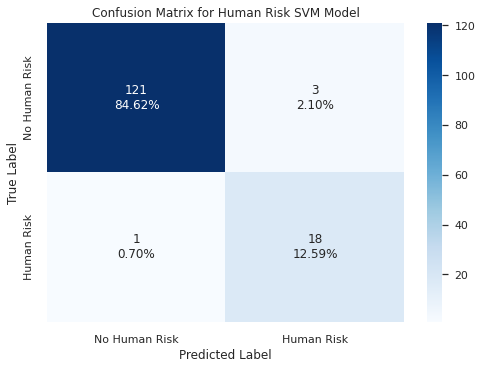

In [ ]:
plot_confusion_matrix_heatmap(y_test, svm_preds, ordered_labels_list = [0, 1], labels = ["No Human Risk", "Human Risk"], title = "Confusion Matrix for Human Risk SVM Model")
plt.savefig(join(CLASSIFICATION_PLOTS_DIR, "human_risk_cm_svm.png"), bbox_inches = 'tight', dpi = 150)

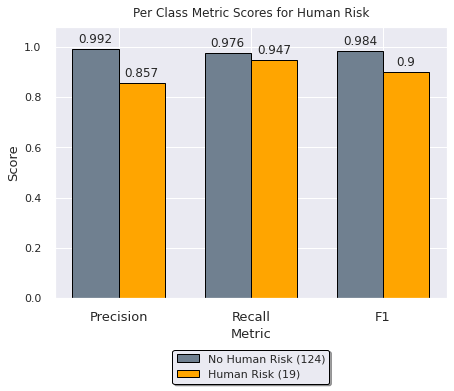

In [ ]:
ordered_human_dam_categories = ["no_human_risk", "human_risk"]
fig = plot_per_class_metric_bar_chart("human_risk", 
                                      y_test, 
                                      svm_preds, 
                                      human_risk_class_str_idx_map, 
                                      ordered_human_dam_categories, 
                                      fig_size = (9, 5), 
                                      width = 0.35, 
                                      label_size = 13,
                                      title_padding = 10, 
                                      colors = ['slategray', 'orange'],
                                      legend_outside_plot = True)
# Had to maneuver the legend to be outside the plot since the performance bars were interfering with the legend
plot_margin=0.08
x0, x1, y0, y1 = plt.axis()
plt.axis((x0, x1, y0, y1 + plot_margin))
plt.legend(bbox_to_anchor = (0.30, -0.19), loc = 'upper left', borderaxespad = 0, edgecolor = 'black', shadow = True, frameon = True)
fig.savefig(join(CLASSIFICATION_PLOTS_DIR, "human_risk_per_class_metric.png"), bbox_inches = 'tight', dpi = 150)

#### **Area Under the Precision-Recall Curve (AUCPR)**

In [ ]:
from url_text_module import (
    STRATIFIED_STR,
    compute_aucpr,
    plot_precision_recall_curve_for_model
)

In [ ]:
# Code inspired from https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [ ]:
# calculate the precision-recall auc for dummy classifier which always predicts 'Human Risk'
aucpr_all_pos = compute_aucpr(y_test, all_pos_probas[:, 1])
print('Always predicts 1 AUCPR: %.3f' % aucpr_all_pos)

Always predicts 1 AUCPR: 0.566


In [ ]:
# calculate the precision-recall auc for dummy classifier which respects the training class distributions
stratified_dummy_options = {STRATEGY_KEY: STRATIFIED_STR, RANDOM_STATE_STR: SEED}
stratified_preds, stratified_probas = get_dummy_classifier_preds_and_probs(stratified_dummy_options, train_bert_embeddings, y_train, test_bert_embeddings)
aucpr_stratified = compute_aucpr(y_test, stratified_probas[:, 1])
print('No Skill AUCPR: %.3f' % aucpr_stratified)

No Skill AUCPR: 0.334


In [ ]:
decision_func_scores = fitted_svm_grid_search_obj.decision_function(test_bert_embeddings)
svm_aucpr_score = compute_aucpr(y_test, decision_func_scores)
print(f'SVM AUCPR score on test data: {svm_aucpr_score}')

SVM AUCPR score on test data: 0.9189100943052382


In [ ]:
model_name = SUPPORT_VECTOR_MACHINE_KEY
title = 'Precision-Recall Curve for Human Risk SVM Model'

SVM: f2=0.928 aucpr=0.919


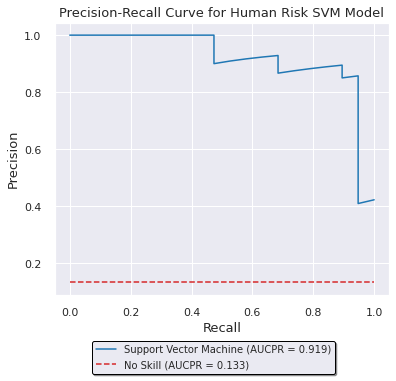

In [ ]:
# summarize scores
print('SVM: f2=%.3f aucpr=%.3f' % (svm_test_f2, svm_aucpr_score))
# Plot precision-recall curve for fitted SVM model
plot_precision_recall_curve_for_model(
    model_name,
    decision_func_scores,
    y_test,
    title = title,
    save_path = join(CLASSIFICATION_PLOTS_DIR, "human_risk_precision_recall_curve_svm.png")
)

### Refit model on entire dataset, i.e. both training and test, then save to host's filesystem for future inference

In [ ]:
from url_text_module import (
    ModelMetadata,
    create_directory_and_save_model_metadata,
    load_sklearn_model
)

In [ ]:
full_X = np.array(human_risk_dataset[EMBEDDINGS_COL_NAME].to_list())

In [ ]:
svm_model = fitted_svm_grid_search_obj.estimator
svm_model.fit(full_X, y)

Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('classifier', SVC(random_state=1))])

In [ ]:
svm_hyperparams = {name.split('__')[1]: value for name, value in fitted_svm_grid_search_obj.best_params_.items()}
model_name = 'svm_human_risk'
svm_model_metadata = ModelMetadata(
    model_name, 
    svm_model,
    human_risk_class_str_idx_map, 
    svm_hyperparams, 
    best_featurization, 
    all_algos_metadata_dict[SUPPORT_VECTOR_MACHINE_KEY].normalizer_type, 
    SEED
)

In [ ]:
svm_model_dir = create_directory_and_save_model_metadata(
    CLASSIFICATION_PLOTS_DIR,
    svm_model_metadata
)

In [ ]:
svm_model_loaded = load_sklearn_model(svm_model_dir, model_name)

In [ ]:
from url_text_module import (
    create_input_string_preprocessor
)

In [ ]:
svm_input_str_preprocessor = create_input_string_preprocessor(best_featurization)

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/517 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/427M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Predict on unseen, unlabeled **RiskMap Typhoon Hagibis** text data

In [ ]:
typhoon_hagibis_csv_path = "/content/drive/MyDrive/05_REACT AI/Research/AI & ML/REACT Simulation/jp.riskmap.org.csv"
riskmap_df = pd.read_csv(typhoon_hagibis_csv_path)

In [ ]:
idx_to_class_dict = {idx: class_name for class_name, idx in human_risk_class_str_idx_map.items()}
for idx, row in riskmap_df.iterrows():
  text = row['text']
  embedded_text = svm_input_str_preprocessor(text)
  predicted_hum_risk_int_label, prediction_score = svm_model_loaded.predict(embedded_text)[0], svm_model_loaded.decision_function(embedded_text)[0]
  class_name_label = idx_to_class_dict[predicted_hum_risk_int_label]
  print(f'Text: {text}')
  print(f'Predicted Label: {class_name_label}')
  print(f'Decision Function Score: {prediction_score}\n')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Text: 高台で自宅は無事ですが、眼前の黒目川周辺地域は避難勧告が出ました
Predicted Label: human_risk
Decision Function Score: 0.008499480556596106

Text: 近くの黒目川はまた溢れていません
Predicted Label: no_human_risk
Decision Function Score: -0.7100695606972732

Text: 護岸を超えて波がどうろに
Predicted Label: no_human_risk
Decision Function Score: -0.9384414677956463

Text: 雨風ともに安定していますが、多摩川が心配で
Predicted Label: no_human_risk
Decision Function Score: -0.9577014405043922

Text: 黒目川の水位が上昇しているため、午後３時３０分に警戒レベル４の避難勧告を発令しました。それに伴い、市民の安全を確保するため、新たにゆめぱれす（朝霞市民会館)を避難所として開設しました。
Predicted Label: no_human_risk
Decision Function Score: -0.5001094615340225

Text: 隅田川テラスの遊歩道しんすい
Predicted Label: no_human_risk
Decision Function Score: -0.8916666333741781

Text: まだ浸水被害は無い
Predicted Label: no_human_risk
Decision Function Score: -0.8813961028291075

Text: 雨風は強いが倒木なし
Predicted Label: no_human_risk
Decision Function Score: -1.2545522974242875

Text: 浸水はありません
Predicted Label: no_human_risk
Decision Function Score: -0.8551260250221542

Text: 雨風が強いです。
まだ避難勧告はないて゛す。

Pr